In [1]:
from lisa.utils import *
from lisa.library import *
import lisa.models, pytz
import numpy as np, pandas as pd, datetime
from matplotlib import pyplot as plt, style # for ploting
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools

In [79]:
style.use('ggplot')
np.random.seed(42) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.binary):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
dataset = DataSet.objects.get(id=6)
df = dataset.dataframe
print(df.shape)
df_res = pd.DataFrame(index=df.index, columns=df.columns)
df_mean = df.mean(axis=1)
df_std = df.std(axis=1)
df_quantile_25 = df.quantile(0.25, axis=1)
df_quantile_75 = df.quantile(0.75, axis=1)

(2016, 14)


In [4]:
count=0
for index, row in df.iterrows():
    for column in df.columns:
        IQR = df_quantile_75[index] - df_quantile_25[index]
        
        if row[column] < (df_quantile_25[index] - (1.5 * IQR)) or row[column] > (df_quantile_75[index] + (1.5 * IQR)):
            df_res.loc[index, column] = 1
            count+=1
            #print(index)
            #print('Val:', np.abs(row[column]))
            #print('Mean:', df_mean[index])
            #print('2 Std:', 2*df_std[index])
print(count)
print(df_res.sum(axis=0))

287
station
23      9.0
24     13.0
25     13.0
26      NaN
27     70.0
28      NaN
29     34.0
30      NaN
31      NaN
32      NaN
33      NaN
34      NaN
35    148.0
37      NaN
dtype: float64


In [5]:
indexes = []
for index, row in df_res.iterrows():
    for column in df_res.columns:
        if row[column] == 1:
            indexes.append(index)
            break
print(len(indexes))

222


In [6]:
df_class = pd.DataFrame(index=df.index)
df_class['Class'] = 0

for index in indexes:
    df_class.loc[index,'Class'] = 1
df = df.join(df_class)

In [8]:
# append mean values of each row to dataframe
df_val_mean = df_copy_with_mean(df.drop('Class', axis=1))

df_lisa_station_results = []
    
for station in dataset.stations.all():
    station_id = station.id
    print("station_id: {0}".format(station_id))

    df_correlation, time_elapsed = pearson(df.drop('Class', axis=1), station_id, window_size=16, min_periods=None)
    row_standardized = True
    if row_standardized:
        df_correlation = df_row_standardized(df_correlation)

    df_lisa_results, lisa_time_elapsed = df_lisa_time_series(station_id, df_val_mean, df_correlation)
    df_lisa_station_results.append(df_lisa_results)

df_lisa = pd.DataFrame(index=df.index)
for result in df_lisa_station_results:
    df_lisa = df_lisa.join(result)

station_id: 23
Execution time for pearson values for series: 0:00:00.139935
Execution time for lisa values: 0:00:03.064224
station_id: 24
Execution time for pearson values for series: 0:00:00.049037
Execution time for lisa values: 0:00:03.013976
station_id: 25
Execution time for pearson values for series: 0:00:00.048814
Execution time for lisa values: 0:00:03.564182
station_id: 26
Execution time for pearson values for series: 0:00:00.063523
Execution time for lisa values: 0:00:04.564943
station_id: 27
Execution time for pearson values for series: 0:00:00.062835
Execution time for lisa values: 0:00:03.596617
station_id: 28
Execution time for pearson values for series: 0:00:00.069879
Execution time for lisa values: 0:00:03.823363
station_id: 29
Execution time for pearson values for series: 0:00:00.048021
Execution time for lisa values: 0:00:03.145693
station_id: 30
Execution time for pearson values for series: 0:00:00.051178
Execution time for lisa values: 0:00:03.336894
station_id: 31
E

In [60]:
df_res = df_res.fillna(value=0)
print(len(df_res[23].values))
df_lisa = df_lisa.fillna(value=0)
y_pred_score = df_lisa[29].values
print(y_pred_score)

2016
[ 0.          0.          0.         ..., -0.00888928 -0.00983127
 -0.00886267]


In [61]:
tresholds = np.linspace(0, -1, 100)
scores = []
y_pred_score = df_lisa[29].values
for treshold in tresholds:
    y_hat = (y_pred_score < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=df_res[29].values),
                 precision_score(y_pred=y_hat, y_true=df_res[29].values),
                 fbeta_score(y_pred=y_hat, y_true=df_res[29].values, beta=1)])

scores = np.array(scores)

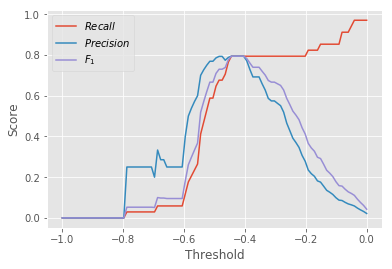

In [78]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_1$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

-0.40404040404040409

Final threshold: -0.404
Recall Score: 0.794
Precision Score: 0.794
F1 Score: 0.794


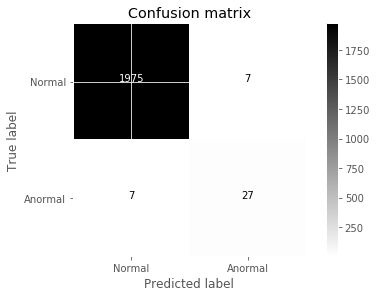

In [81]:
final_tresh = tresholds[scores[:, 2].argmax()]
#final_tresh = -0.4
y_hat_test = (df_lisa[29].values < final_tresh).astype(int)

print('Final threshold: %.3f' % final_tresh)
print('Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=df_res[29].values))
print('Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=df_res[29].values))
print('F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=df_res[29].values, beta=1))

cnf_matrix = confusion_matrix(df_res[29].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

In [48]:
#gets all anormal instances
df[(model.predict(df_n.drop('Class', axis=1).values) < final_tresh)].shape

(623, 15)

Final threshold: 21
Test Recall Score: 0.468
Test Precision Score: 0.283
Test F1 Score: 0.353


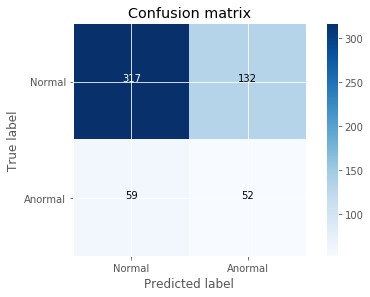

In [41]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.predict(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=1))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')